# Data Mining Project

* Alex Panchot (M20190546)
* Hugo Mentzingen (M20190215)
* Rennan Valadares (M20190146)

In [0]:
#remove warnings
import warnings
warnings.filterwarnings("ignore")

#Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.svm import LinearSVR
import seaborn as sns
from sklearn import preprocessing

In [0]:
#Global variables
env_params = {
    "Outliers" : [655,5084,7195,5882,8261,171,5293,8866,9149,7961,5293,5211,6835],
    "NoisyData" : [9294], #First Policy´s Year = 53784.0
    "InsConColumns" : ['Premiums in LOB: Motor',
                       'Premiums in LOB: Household',
                       'Premiums in LOB: Health',
                       'Premiums in LOB:  Life',
                       'Premiums in LOB: Work Compensations',
                       'Premium: Sum'],
    "ValEngColumns" : ['Educational Degree',
                       'Geographic Living Area',
                       'Has Children (Y=1)',
                       'Gross Monthly Salary',
                       'Customer Monetary Value',
                       'Claims Rate',
                       'Age',
                       'First Policy´s Age'],
    "CategoricalColumns" : ['Educational Degree',
                            'Geographic Living Area',
                            'Has Children (Y=1)'],
    "NumericalColumns" : ['First Policy´s Year',
                          'Gross Monthly Salary',
                          'Customer Monetary Value',
                          'Claims Rate',
                          'Premiums in LOB: Motor',
                          'Premiums in LOB: Household',
                          'Premiums in LOB: Health',
                          'Premiums in LOB:  Life',
                          'Premiums in LOB: Work Compensations',
                          'Age',
                          'First Policy´s Age',
                          'Premium: Sum']
}

In [0]:
#Function to split the DataFrame in data complete and incomplete
#The rows that belong to the 'incomplete' dataframe have at least one NaN
def split(data_insurance, reset_index = False):
    data_insurance_complete = pd.DataFrame()
    data_insurance_incomplete = data_insurance[data_insurance.isna().any(axis=1)]
    if reset_index:
        data_insurance_incomplete.reset_index(inplace=True)
        data_insurance_incomplete.drop('index', axis=1, inplace=True)
    data_insurance_complete = data_insurance[~data_insurance.isna().any(axis=1)]
    return data_insurance_complete, data_insurance_incomplete

In [0]:
#Function to plot the correlation between variables
def plotCorrelation(df):
    sns.set()
    fig, ax = plt.subplots(figsize=(9,6))
    sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2f', cmap='RdBu', vmin=-1, vmax=1, linewidths=.9, ax = ax).set_title('Variables correlation')
    ax.set_xticks(np.arange(df.corr(method='pearson').shape[1]+1), minor=True)
    ax.set_yticks(np.arange(df.corr(method='pearson').shape[0]+1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=True, left=True)

In [0]:
#Function to separate the dataframe into 'Insurance Consumption' and 'Value & Engagement' features
def separateVariables(df):
    InsCon = df[env_params['InsConColumns']]
    ValEng = df[env_params['ValEngColumns']]

    return InsCon, ValEng

In [0]:
#Function to rescale or normalize the dataframe columns
def rescaleAndNormalize(data_insurance):
    
    data_insurance_ = deepcopy(data_insurance)
    data_insurance_.drop(env_params['Outliers'], inplace=True)

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(data_insurance_.drop(columns=env_params['CategoricalColumns'], axis = 1))
    scaled_features = pd.DataFrame(scaled_features, columns = data_insurance_.drop(columns=env_params['CategoricalColumns']).columns)
    scaled_data_insurance = pd.merge(scaled_features, data_insurance_[env_params['CategoricalColumns']], left_index=True, right_index=True)

    return scaled_data_insurance

In [0]:
#Function to evaluate the best n_neighbors to use with KNN
def evaluateClassifier(data_insurance):
    data_insurance_complete, data_insurance_incomplete = split(data_insurance, reset_index=True)

    def createAndFitClassifier(k):
        clf = KNeighborsClassifier(n_neighbors=k)    
        incomplete = deepcopy(data_insurance_incomplete)
        complete = deepcopy(data_insurance_complete)   
        X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != value].values,
                                                            complete.loc[:,value].values, test_size = 0.2, random_state = 0)
        trained_model = clf.fit(X_train, y_train)
        result = [clf, y_test, X_test, trained_model, incomplete, complete]
        return result
    
    accuracies_for_value_dict = {}

    for index, value in enumerate(env_params['CategoricalColumns']):

        accuracy_dict = {}

        for k in range(3,30):

            result = createAndFitClassifier(k)
            clf = result[0]
            y_test = result[1]
            X_test = result[2]                                                
            
            #calculate the model accuracy and storing the value into a dictionary
            y_pred = clf.predict(X_test)
            accuracy_matrix = confusion_matrix(y_test, y_pred)
            accuracy = accuracy_matrix.trace()/accuracy_matrix.sum()
            accuracy_dict[k] = accuracy
        
        accuracies_for_value_dict[value] = accuracy_dict
    
    return accuracies_for_value_dict


In [0]:
#Function that uses KNN to classify the missing values on CATEGORICAL columns
def classifyCategoricalData(data_insurance, n_neighbors_dict):
    data_insurance_complete, data_insurance_incomplete = split(data_insurance, reset_index=True)
  
    #Creating a classifier to fill the categorical data: Educational Degree, Geographic Living Area and Has Children (Y=1)
    for index, value in enumerate(env_params['CategoricalColumns']):

        clf = KNeighborsClassifier(n_neighbors=n_neighbors_dict[value])    
        
        incomplete = deepcopy(data_insurance_incomplete)
        complete = deepcopy(data_insurance_complete)
        
        X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != value].values,
                                                            complete.loc[:,value].values, test_size = 0.2, random_state = 0)
        
        trained_model = clf.fit(X_train, 
                                 y_train)
           
        #fill the numerical columns with the column mean
        incomplete.loc[:, ~incomplete.columns.isin(env_params['CategoricalColumns']) ] = incomplete.loc[:, 
                                ~incomplete.columns.isin(env_params['CategoricalColumns'])].apply(lambda column: column.fillna(column.mean()), axis=0)
        
        #Round Age and First Policy's Year
        incomplete['Age'] = incomplete['Age'].apply(lambda x:round(x))
        incomplete['First Policy´s Age'] =  incomplete['First Policy´s Age'].apply(lambda x:round(x))
                
        #Categorical columns with the exception of the one we want to predict
        cat_without_the_column = deepcopy(env_params['CategoricalColumns'])
        cat_without_the_column.pop(index)
        
        #Fill the categorical columns with the exception of the one we want to predict with the mode
        #(Hugo) Here I corrected the function to dataframe.mode instead of .mean
        incomplete.loc[:, incomplete.columns.isin(cat_without_the_column) ] = incomplete.loc[:, 
                        incomplete.columns.isin(cat_without_the_column)].apply(lambda column: column.fillna(int(column.mode())), axis=0)
              
        prediction = trained_model.predict(incomplete.loc[:,incomplete.columns != value])
        temp_df = pd.DataFrame(prediction.reshape(-1,1), columns = [value])
        
        
        #now we are filling data_insurance_incomplete 
        for ind in range(len(temp_df)):
            if np.isnan(data_insurance_incomplete[value][ind]):
                data_insurance_incomplete[value][ind] = temp_df[value][ind]


    #and reconstructing the original dataframe
    dataset = pd.concat([data_insurance_complete, data_insurance_incomplete])
    dataset.set_index(dataset['Customer Identity'] - 1, inplace=True)
    
    return dataset

In [0]:
#funcion for checking which algorithm is the best for using on each column for NUMERICAL columns
def checking_choices(data_insurance, number_of_tests=10):
    data_insurance_complete, data_insurance_incomplete = split(data_insurance)

    choices = []
    better_for_each_column = []
    
    #testing
    for i in range(number_of_tests):
        choices.append(regressor_test(data_insurance))
    
    #chosing the best algorithm for each column
    for i in range(len(data_insurance.columns)):
        l = []
        for j in range(len(choices)):
            l.append(choices[j][i])
        better_for_each_column.append(max(set(l), key = l.count))
        
    return better_for_each_column

In [0]:
#function for test which regressor is best for each numerical column
#Return a list of lists with the best algorithm for each test (choose the number of tests on checking_choices function )
def regressor_test(data_insurance):
#variables to hold the Mean Squared Errors for each model
    kn_errors = []
    linear_errors = []
    svr_errors = []    
    
    complete,incomplete = split(data_insurance)
    
    for i in complete.columns:
            
        X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != i].values,
                                                            complete.loc[:,i].values, test_size = 0.2, random_state = 0)
        
        regressor1 = KNeighborsRegressor(5, 
                                       weights ='distance', 
                                       metric = 'euclidean')
        regressor2= LinearRegression()
        regressor3=LinearSVR()
        
        
        KN_trained_model1 = regressor1.fit(X_train, 
                                 y_train)
        Linear_trained_model2 = regressor2.fit(X_train, 
                                 y_train)
        SVR_trained_model3 = regressor3.fit(X_train, 
                                 y_train)  
        
        incomplete_2 = deepcopy(incomplete)
        incomplete_2.loc[:, incomplete.columns != i] = incomplete_2.loc[:, 
                                incomplete.columns != i].apply(lambda row: row.fillna(row.mean()), axis=1)

        y_pred1 = regressor1.predict(X_test)
        y_pred2 = regressor2.predict(X_test)
        y_pred3 = regressor3.predict(X_test)
        
        
        kn_errors.append(math.sqrt(mean_squared_error(y_test, y_pred1)))
        linear_errors.append(math.sqrt(mean_squared_error(y_test, y_pred2)))
        svr_errors.append(math.sqrt(mean_squared_error(y_test, y_pred3)))
        
        
    #ROOT MEAN SQUARED ERROR 
    RMSE= []

    #Filling RMSE for each column
    for i in range(0, len(complete.columns)):
        l = []
        l.extend((kn_errors[i], linear_errors[i], svr_errors[i]))
        
        if min(l) == kn_errors[i]:
            RMSE.append("KNN")
        elif min(l) == linear_errors[i]:
            RMSE.append("Linear")
        elif min(l) == svr_errors[i]:
            RMSE.append("SVR")
    


    return RMSE

In [0]:
#function to apply the regressors
def apply_regressors(choices, data_insurance, numerical_columns):

    complete,incomplete = split(data_insurance)

    for i,v in enumerate(complete.columns):
        
        #Check if it is a numerical column
        if v in numerical_columns:
            
            #use the choosen algorithm 
            if choices[i] == 'KNN':
                regressor = KNeighborsRegressor(5, 
                                                weights ='distance', 
                                                metric = 'euclidean')
            elif choices[i] == 'SVR':
                regressor = LinearSVR()
                
            elif choices[i] == 'Linear':
                regressor = LinearRegression()
                
            #Split in train-test data    
            X_train, X_test, y_train, y_test = train_test_split(complete.loc[:,complete.columns != v].values,
                                                                complete.loc[:,v].values, test_size = 0.2, random_state = 0)
            #Train the model
            trained_model = regressor.fit(X_train, 
                                     y_train)
            
            #Make predictions
            incomplete_2 = deepcopy(incomplete)
            incomplete_2.loc[:, incomplete.columns != v] = incomplete_2.loc[:, 
                                    incomplete.columns != v].apply(lambda row: row.fillna(row.mean()), axis=1)
            
            prediction = trained_model.predict(incomplete_2.loc[:,incomplete_2.columns != v])
            temp_df = pd.DataFrame(prediction.reshape(-1,1), columns = [v])
            
            #fill NaN's on data_arrivals_incomplete 
            for index in range(len(temp_df)):
                if np.isnan(incomplete.iloc[index,i]):
                    incomplete.iloc[index,i] = temp_df[v][index]



    #and filling the nan's on arrivals_df
    dataset = pd.concat([complete, incomplete])
    dataset.set_index(dataset['Customer Identity'] - 1, inplace=True)
    
    
    return dataset

In [0]:
#Given two features (columns) this function plots a quartile matrix (number of customer on each quartile cell)

def quartileMatrix(df, feature1, feature2):
  quartile_id = ['q1','q2','q3','q4']
  df['f1_quartile'] = pd.qcut(df[feature1], 4, quartile_id)
  df['f2_quartile'] = pd.qcut(df[feature2], 4, quartile_id)
  quartiles_df = pd.DataFrame(index=quartile_id, columns=quartile_id)

  for i in quartile_id:
      for j in quartile_id:
          quartiles_df.ix[i,j] = len(df[(df["f1_quartile"]==i) & (df["f2_quartile"]==j)])
  
  return quartiles_df
 


In [0]:
#_________________________Cleaning and Filling the Data with the algorithms___________________________________________

#Read the dataset
insurance_df = pd.read_csv('https://raw.githubusercontent.com/apanchot/data_mining/master/A2Z_Insurance.csv?token=ANHK7VCNE3LUXISDBRLXCM252CMEK')

#Create Age column
insurance_df['Age'] = insurance_df.loc[:, 'Brithday Year'].apply(lambda x : 2019 - x )

#Create First Policy´s Age column
insurance_df['First Policy´s Age'] = insurance_df.loc[:, 'First Policy´s Year'].apply(lambda x : 2019 - x )

#Drop Birthday Year and First Policy´s Year
insurance_df.drop(['Brithday Year', 'First Policy´s Year' ], axis=1, inplace=True)

In [0]:
#Drop rows with more than 3 NaN's
insurance_df.dropna(thresh=(len(insurance_df.columns) - 3), inplace=True, axis=0)

In [16]:
#Counting the rows with 'First Policy´s Age' > 'Age'
#It shows us a possible problem with the data
insurance_df[insurance_df['First Policy´s Age'] > insurance_df['Age']].shape[0]

1994

In [17]:
#Proportion of customers below 21 that have children
#Is 'Age' trustworthy?
x = insurance_df[(insurance_df['Age'] <= 21) & (insurance_df['Has Children (Y=1)'] == 1)].shape[0]
y = insurance_df[(insurance_df['Age'] <= 21) & (insurance_df['Has Children (Y=1)'] == 0)].shape[0]
print("{:.2f}".format(x/(x+y)*100),'%')

76.08 %


In [0]:
data_insurance = deepcopy(insurance_df)

#Dropping row(s) with evident noisy (corrupted or distorted) values in the dataframe
data_insurance.drop(env_params['NoisyData'], inplace=True)

#Encoding Educational Degree and returning back the NaN's
data_insurance['Educational Degree'] = data_insurance['Educational Degree'].apply(str)

labelencoder_X = LabelEncoder()

data_insurance.loc[:,'Educational Degree'] = labelencoder_X.fit_transform(data_insurance.loc[:,'Educational Degree'])

data_insurance['Educational Degree'] = data_insurance['Educational Degree'].apply(lambda x : np.nan if x == 4 else x )

#Adding the sum of all premiums paid as a column 
data_insurance['Premium: Sum']=data_insurance[['Premiums in LOB: Work Compensations',
                                                         'Premiums in LOB:  Life',
                                                         'Premiums in LOB: Health',
                                                         'Premiums in LOB: Household',
                                                         'Premiums in LOB: Motor']].sum(axis=1)

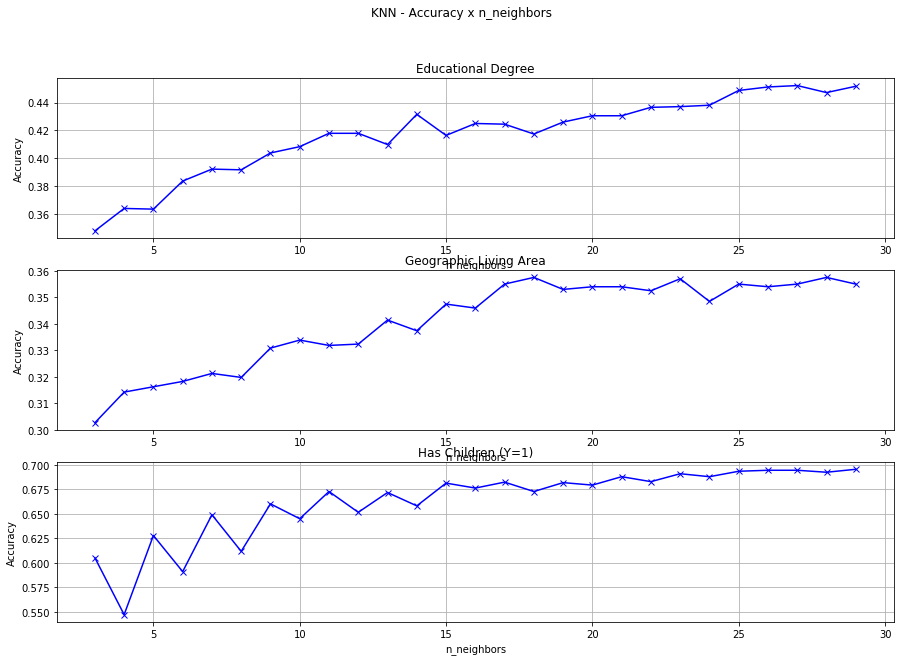

In [19]:
#Verify the optimal n_neighbors to our KNN classifiers
scaled_data_insurance = rescaleAndNormalize(data_insurance)
scaled_data_insurance.drop('Customer Identity', axis=1)

accuracies_for_column_dict = evaluateClassifier(scaled_data_insurance)
fig, ax = plt.subplots(3, figsize=(15,10))
fig.suptitle('KNN - Accuracy x n_neighbors')
ax[0].plot(list(accuracies_for_column_dict['Educational Degree'].keys()),
                                    list(accuracies_for_column_dict['Educational Degree'].values()),
                                    'bx-') 
ax[0].set_title('Educational Degree')
ax[0].grid(True)

ax[1].plot(list(accuracies_for_column_dict['Geographic Living Area'].keys()),
                                    list(accuracies_for_column_dict['Geographic Living Area'].values()),
                                    'bx-') 
ax[1].set_title('Geographic Living Area')
ax[0].grid(True)

ax[2].plot(list(accuracies_for_column_dict['Has Children (Y=1)'].keys()),
                                    list(accuracies_for_column_dict['Has Children (Y=1)'].values()),
                                    'bx-') 
ax[2].set_title('Has Children (Y=1)')
ax[2].grid(True)

for ax in ax.flat:
    ax.set(xlabel='n_neighbors', ylabel='Accuracy')

plt.show()

In [0]:
#Setting the optimal number of neighbors to each categorical column regression
n_neighbors_dict = {'Educational Degree' : 11,
                    'Geographic Living Area' : 10,
                    'Has Children (Y=1)' : 11}

In [0]:
#Preparing to plot correlation
plot_data_insurance = deepcopy(data_insurance)
plot_data_insurance.drop(env_params['Outliers'], inplace=True)
plot_data_insurance.drop('Customer Identity', axis=1, inplace=True)

In [0]:
#Separating variables
InsCon, ValEng = separateVariables(plot_data_insurance)

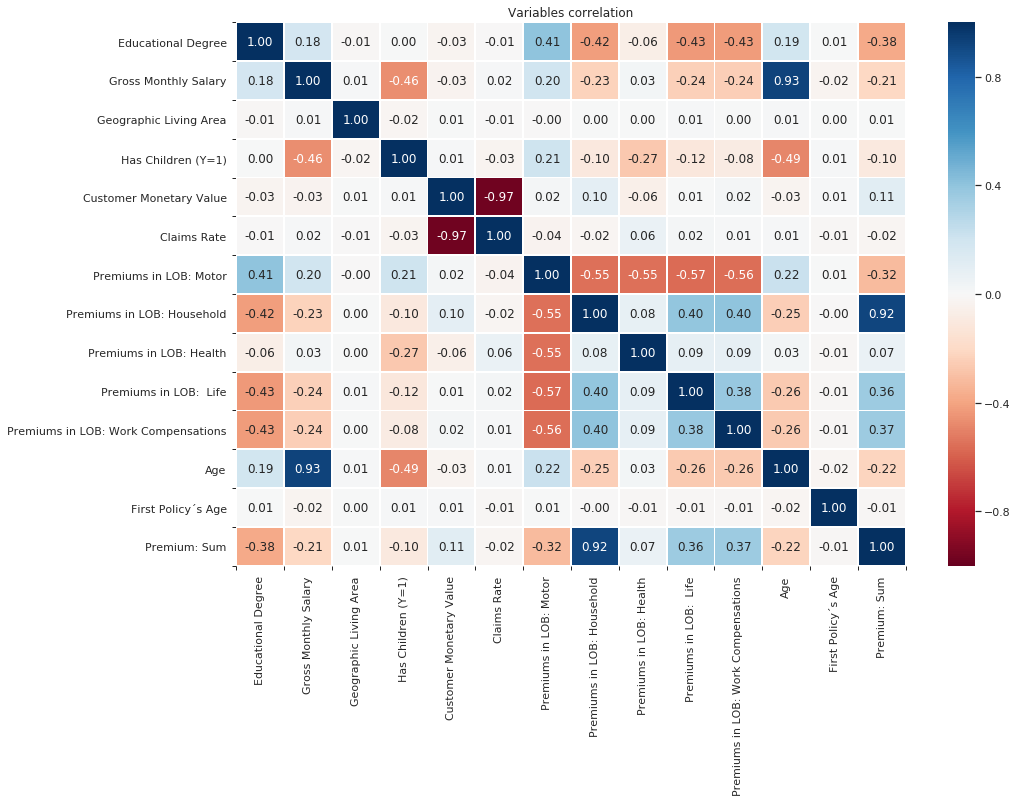

In [115]:
#Plotting the correlation between all variables
plotCorrelation(plot_data_insurance)

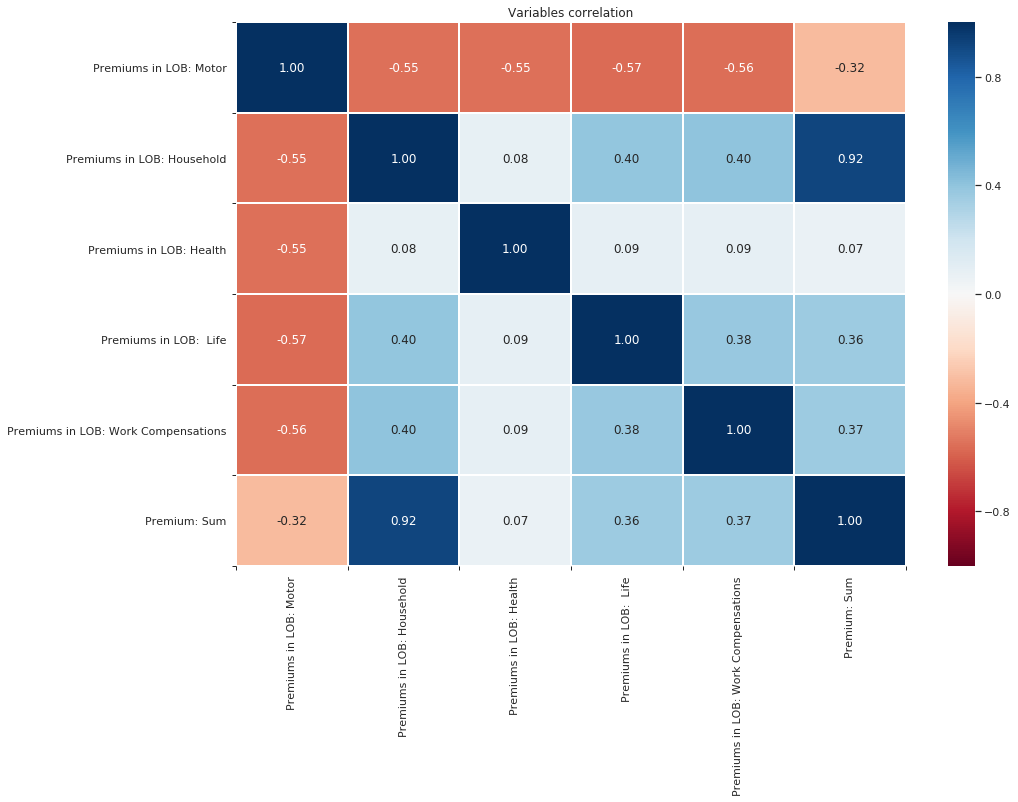

In [116]:
#Plotting the correlation between Insurance Consumption variables
plotCorrelation(InsCon)

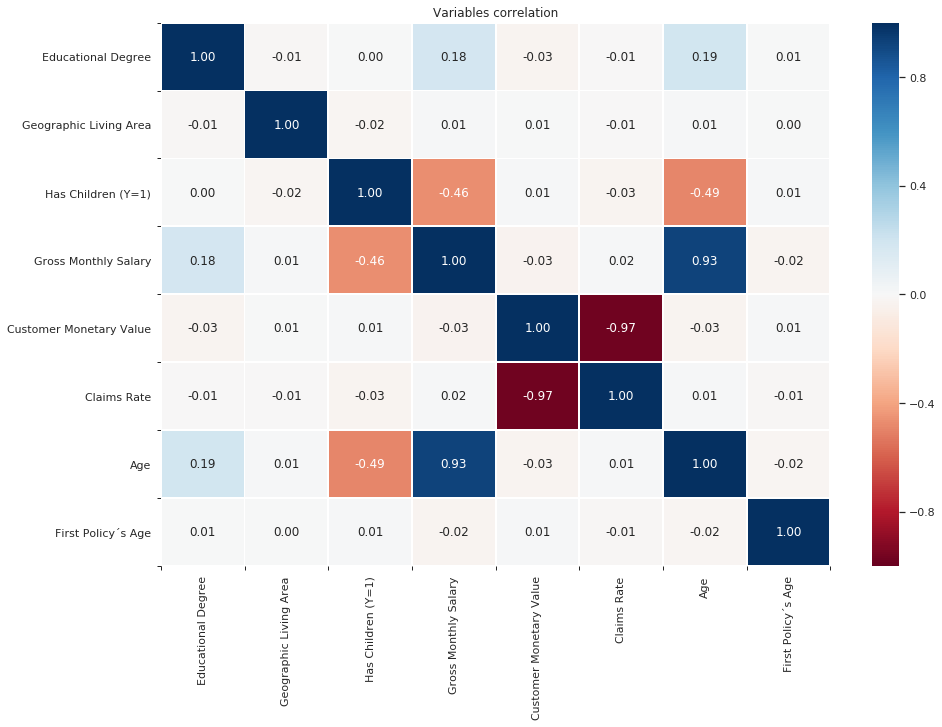

In [117]:
#Plotting the correlation between Customer Value & Engagement variables
plotCorrelation(ValEng)

In [0]:
def quartilePlotter(df, y_variables, x_variable):

  f,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(18,3.6), gridspec_kw={'width_ratios':[1,1,1,1,1]})
  ax1.get_shared_y_axes().join(ax2,ax3,ax4,ax5)

  g1 = sns.heatmap(quartileMatrix(df, y_variables[0], x_variable), annot=True, fmt="d", cmap="Greens",cbar=False,ax=ax1)
  g1.set_ylabel(y_variables[0])
  g1.set_xlabel(x_variable)
  g1.set_ylim(4,0)
  g2 = sns.heatmap(quartileMatrix(df, y_variables[1], x_variable), annot=True, fmt="d", cmap="Greens",cbar=False,ax=ax2)
  g2.set_ylabel(y_variables[1])
  g2.set_xlabel(x_variable)
  g2.set_yticks([])
  g3 = sns.heatmap(quartileMatrix(df, y_variables[2], x_variable),cmap="Greens", annot=True, fmt="d", cbar=False, ax=ax3)
  g3.set_ylabel(y_variables[2])
  g3.set_xlabel(x_variable)
  g3.set_yticks([])
  g4 = sns.heatmap(quartileMatrix(df, y_variables[3], x_variable), annot=True, fmt="d", cmap="Greens",cbar=False,ax=ax4)
  g4.set_ylabel(y_variables[3])
  g4.set_xlabel(x_variable)
  g4.set_yticks([])
  g5 = sns.heatmap(quartileMatrix(df, y_variables[4], x_variable),cmap="Greens", annot=True, fmt="d", cbar=False, ax=ax5)
  g5.set_ylabel(y_variables[4])
  g5.set_xlabel(x_variable)
  g5.yaxis.tick_right()
  g5.set_ylim(4, 0)


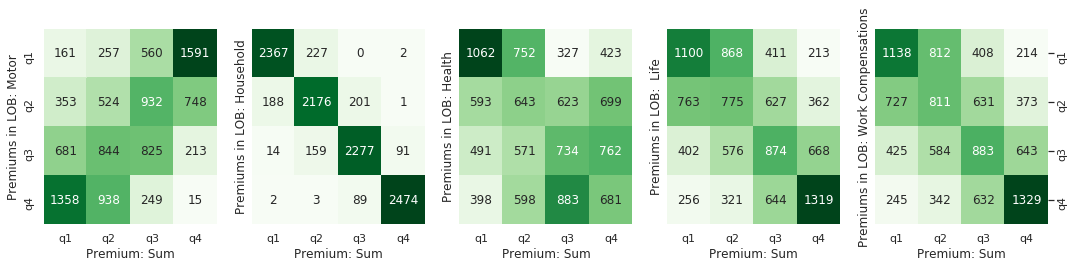

In [125]:
#Plotting the quartile matrix for Insurance Consumption features
#Show insurance type sales potential in relation to sum of premiums

y_variables = ['Premiums in LOB: Motor',
               'Premiums in LOB: Household',
               'Premiums in LOB: Health',
               'Premiums in LOB:  Life',
               'Premiums in LOB: Work Compensations']
x_variable = 'Premium: Sum'

quartilePlotter(InsCon, y_variables, x_variable)

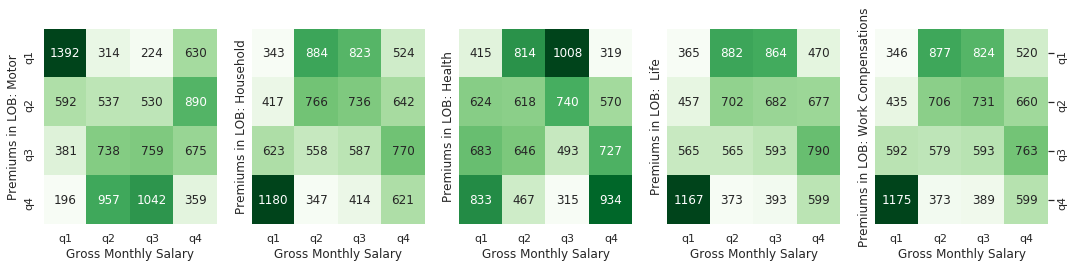

In [135]:
#Plotting the quartile matrix for Insurance Consumption features versus Salary
#Show insurance type sales potential in relation to salary

y_variables = ['Premiums in LOB: Motor',
               'Premiums in LOB: Household',
               'Premiums in LOB: Health',
               'Premiums in LOB:  Life',
               'Premiums in LOB: Work Compensations']
x_variable = 'Gross Monthly Salary'

quartilePlotter(plot_data_insurance, y_variables, x_variable)

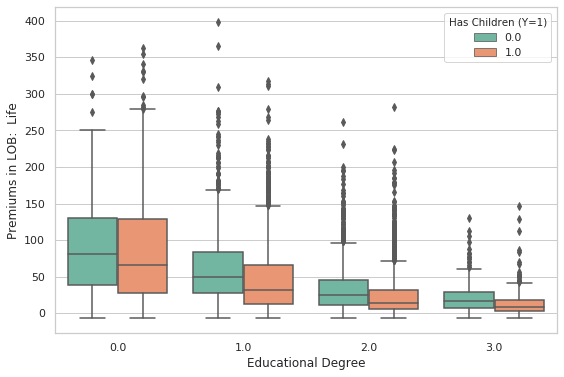

In [140]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(x='Educational Degree', y='Premiums in LOB:  Life', hue='Has Children (Y=1)', data=plot_data_insurance, palette="Set2")

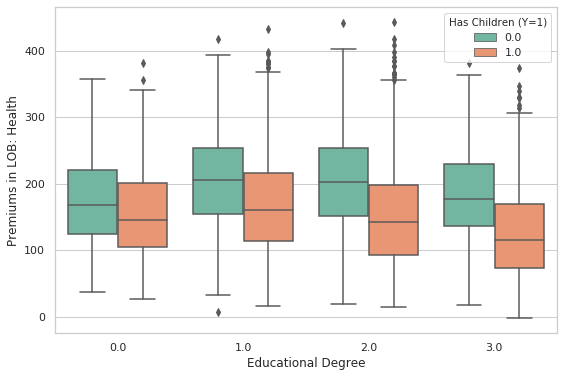

In [142]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.boxplot(x='Educational Degree', y='Premiums in LOB: Health', hue='Has Children (Y=1)', data=plot_data_insurance, palette="Set2")

In [0]:
#Fill categorical data with the KNN predicted Values
data_insurance = classifyCategoricalData(data_insurance, n_neighbors_dict)

In [0]:
#Fill numerical data with the best regressor algorithm
data_insurance = apply_regressors(checking_choices(data_insurance),data_insurance, env_params['NumericalColumns'])


#Full dataset
data_insurance.isnull().sum()

In [0]:
#_________________________Checking the distributions, correlations and outliers___________________________________________

#Age x Premiuns
sns.set_style("ticks")
sns.pairplot(data_insurance[['Age',
                             'Premiums in LOB: Motor',
                             'Premiums in LOB: Household',
                             'Premiums in LOB: Health',
                             'Premiums in LOB:  Life',
                             'Premiums in LOB: Work Compensations']],
            diag_kind='hist',
            kind='scatter',
            palette="husl",
           plot_kws = {'alpha': 0.6,
                      's': 20,
                      'edgecolor':'k'},
           height=2)

plt.show()

In [0]:
#Education x Premiums
sns.set_style("ticks")
sns.pairplot(data_insurance[['Educational Degree',
                             'Premiums in LOB: Motor',
                             'Premiums in LOB: Household',
                             'Premiums in LOB: Health',
                             'Premiums in LOB:  Life',
                             'Premiums in LOB: Work Compensations']],
            diag_kind='hist',
            kind='scatter',
            palette="husl",
           plot_kws = {'alpha': 0.6,
                      's': 20,
                      'edgecolor':'k'},
           height=2)

plt.show()

In [0]:
#Gross Monthly x Premiums
#Here we can see 2 outliers on GMS index 5882 and 8261 
sns.set_style("ticks")
sns.pairplot(data_insurance[['Gross Monthly Salary',
                             'Premiums in LOB: Motor',
                             'Premiums in LOB: Household',
                             'Premiums in LOB: Health',
                             'Premiums in LOB:  Life',
                             'Premiums in LOB: Work Compensations']],
            diag_kind='hist',
            kind='scatter',
            palette="husl",
           plot_kws = {'alpha': 0.6,
                      's': 20,
                      'edgecolor':'k'},
           height=2)

plt.show()

In [0]:
#CMV x Premiuns
#Here we can see 1 outlier on GMS index 171
sns.set_style("ticks")
sns.pairplot(data_insurance[['Customer Monetary Value',
                             'Premiums in LOB: Motor',
                             'Premiums in LOB: Household',
                             'Premiums in LOB: Health',
                             'Premiums in LOB:  Life',
                             'Premiums in LOB: Work Compensations']],
            diag_kind='hist',
            kind='scatter',
            palette="husl",
           plot_kws = {'alpha': 0.6,
                      's': 20,
                      'edgecolor':'k'},
           height=2)

plt.show()

In [0]:
#Claims Rate x Premiuns
#Again the 171 is an outlier for Claim Rate, since its the opposite of CMV
sns.set_style("ticks")
sns.pairplot(data_insurance[['Claims Rate',
                             'Premiums in LOB: Motor',
                             'Premiums in LOB: Household',
                             'Premiums in LOB: Health',
                             'Premiums in LOB:  Life',
                             'Premiums in LOB: Work Compensations']],
            diag_kind='hist',
            kind='scatter',
            palette="husl",
           plot_kws = {'alpha': 0.6,
                      's': 20,
                      'edgecolor':'k'},
           height=2)

plt.show()

In [0]:
#Just Premiums
#We have to check each of this outliers
# 5293 for Motor
# 8866 for Household
# 9149 for Health
# 7961 and 7988 for Work Compensation
sns.set_style("ticks")
sns.pairplot(data_insurance[['Premiums in LOB: Motor',
                             'Premiums in LOB: Household',
                             'Premiums in LOB: Health',
                             'Premiums in LOB:  Life',
                             'Premiums in LOB: Work Compensations']],
            diag_kind='hist',
            kind='scatter',
            palette="husl",
           plot_kws = {'alpha': 0.6,
                      's': 20,
                      'edgecolor':'k'},
           height=2)

plt.show()

In [0]:
#_________________________Encoding the data ___________________________________________________________________
#Saving the column names
columns_list = ['Basic','High School', 'BSc/MSc','PhD','Area 1','Area 2','Area 3','Area 4','No Kids','Have Kids']
for i in insurance_df.columns:
    if i not in env_params['CategoricalColumns']:
        columns_list.append(i)

#Should we use dummy variables on educational degree ? My opinion is Yes !
onehotencoder = OneHotEncoder(categorical_features = [2,4,5])
encoded_data = pd.DataFrame(onehotencoder.fit_transform(data_insurance).toarray())

#Give the column names back
encoded_data.columns = columns_list

#Drop identity not needed anymore
encoded_data.drop('Customer Identity', axis=1, inplace=True)
columns_list.remove('Customer Identity')

In [0]:
#_________________________Standardizing the data ___________________________________________________________________

#Should we standardize or normalize the data ? (depends on which ML algorithm we will use)
# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Scaling 
scaled_df = scaler.fit_transform(encoded_data.loc[:,'First Policy´s Year':])
scaled_df = pd.DataFrame(scaled_df)

scaled_data = pd.concat([encoded_data.loc[:,:'Customer Identity'],scaled_df], axis=1)  

scaled_data.columns = columns_list

In [0]:
data_insurance.groupby(['Educational Degree','Geographic Living Area','Has Children (Y=1)'])['Customer Monetary Value'].mean().sort_values(ascending=False)

data_insurance.groupby(['Geographic Living Area','Educational Degree','Has Children (Y=1)'])['Customer Monetary Value'].mean().sort_values(ascending=False)

data_insurance.groupby(['Has Children (Y=1)','Educational Degree','Geographic Living Area'])['Customer Monetary Value'].mean().sort_values(ascending=False)

In [0]:
encoded_data['Premium: Sum']=encoded_data[['Premiums in LOB: Work Compensations','Premiums in LOB:  Life','Premiums in LOB: Health','Premiums in LOB: Household','Premiums in LOB: Motor']].sum(axis=1)

#cluster_binned=data_insurance.loc[:,['Educational Degree','Geographic Living Area', 'Has Children (Y=1)','Premium Sum Binned', 'Gross Monthly Salary Binned','Age Binned', 'Claims Rate Binned']]
cluster_binned=encoded_data.iloc[:,[0,1,2,3,4,5,6,7,8,9,11,13,19,20,12]]
cluster_binned.drop([5692,8013,167,638,9354,658,8870,8597,5122,5041,6621,7722,167,690,890,9354,50,133,738,110,770,954,924,995,6864,6489,10220],inplace=True)
data=pd.DataFrame(preprocessing.minmax_scale(cluster_binned))
#data=cluster_binned
data.columns=encoded_data.columns[[0,1,2,3,4,5,6,7,8,9,11,13,19,20,12]]
data.iloc[:,0:10]=encoded_data.iloc[:,0:10]

ncl=4
centroids,labels,_=k_means(data,n_clusters=ncl,n_init=50,max_iter=200,n_jobs=-1)

plt.figure(figsize=(10,10))
j=1
yl=data.columns[j]
#plt.show()
#plt.ylabel()
#plt.xlabel(data.columns[-1])
for i in range(ncl):
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,4])
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,5])
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,6])
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,7])
    
plt.plot(centroids[:,-1],centroids[:,j],'sg',markersize=10)
plt.show()

In [0]:
cluster_binned=encoded_data.iloc[:,[11,13,19,20,12]]
cluster_binned.drop([5692,8013,167,638,9354,658,8870,8597,5122,5041,6621,7722,167,690,890,9354,50,133,738,110,770,954,924,995,6864,6489,10220],inplace=True)

data=pd.DataFrame(preprocessing.minmax_scale(cluster_binned))
data.columns=encoded_data.columns[[11,13,19,20,12]]
ncl=6
centroids,labels,_=k_means(data,n_clusters=ncl,n_init=50,max_iter=200,n_jobs=-1)

plt.figure(figsize=(10,10))
j=0
for i in range(ncl):
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,j])
plt.plot(centroids[:,-1],centroids[:,j],'sg',markersize=10)

plt.figure(figsize=(10,10))
j=1
for i in range(ncl):
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,j])
plt.plot(centroids[:,-1],centroids[:,j],'sg',markersize=10)

plt.figure(figsize=(10,10))
j=2
for i in range(ncl):
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,j])
plt.plot(centroids[:,-1],centroids[:,j],'sg',markersize=10)

plt.figure(figsize=(10,10))
j=3
for i in range(ncl):
    plt.scatter(data.iloc[labels==i,-1],data.iloc[labels==i,j])
plt.plot(centroids[:,-1],centroids[:,j],'sg',markersize=10)

In [0]:
cluster_binned=encoded_data.iloc[:,[0,1,2,3,4,5,6,7,8,9,11,13,19,20,12]]
cluster_binned.drop([5692,8013,167,638,9354,658,8870,8597,5122,5041,6621,7722,167,690,890,9354,50,133,738,110,770,954,924,995,6864,6489,10220],inplace=True)
data=pd.DataFrame(preprocessing.minmax_scale(cluster_binned))
#data=cluster_binned
data.columns=encoded_data.columns[[0,1,2,3,4,5,6,7,8,9,11,13,19,20,12]]
data.iloc[:,0:10]=encoded_data.iloc[:,0:10]

from sklearn.svm import LinearSVR
regr = LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=0, tol=1e-05, verbose=0)

regr.fit(data.iloc[:8000,:-5], data.iloc[:8000,-2]) 
regr.score(data.iloc[8000:,:-5], data.iloc[8000:,-2])
regr.coef_
regr.intercept_

In [0]:
premiums=deepcopy(insurance_df)
premiums.drop([9294],inplace=True)

plt.figure(figsize=(10,10))
#plt.ylim(-2000,1000)
plt.scatter(2019-premiums["First Policy´s Year"],premiums['Customer Monetary Value'])


premiums['Premium Sum']=premiums[['Premiums in LOB: Work Compensations','Premiums in LOB:  Life','Premiums in LOB: Health','Premiums in LOB: Household','Premiums in LOB: Motor']].sum(axis=1)